In [1]:
import os
import sys

In [2]:
os.environ

environ{'ALLUSERSPROFILE': 'C:\\ProgramData',
        'APPDATA': 'C:\\Users\\LWEST\\AppData\\Roaming',
        'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
        'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
        'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
        'COMPUTERNAME': 'MATM-LWEST',
        'COMSPEC': 'C:\\Windows\\system32\\cmd.exe',
        'CONDA_DEFAULT_ENV': 'mtgml',
        'CONDA_EXE': 'C:\\Users\\LWEST\\Anaconda3\\Scripts\\conda.exe',
        'CONDA_PREFIX': 'C:\\Users\\LWEST\\Anaconda3\\envs\\mtgml',
        'CONDA_PROMPT_MODIFIER': '(mtgml) ',
        'CONDA_PYTHON_EXE': 'C:\\Users\\LWEST\\Anaconda3\\python.exe',
        'CONDA_SHLVL': '1',
        'DOCKER_TOOLBOX_INSTALL_PATH': 'C:\\Program Files\\Docker Toolbox',
        'FP_NO_HOST_CHECK': 'NO',
        'HADOOP_HOME': 'C:\\hadoop\\',
        'HOMEDRIVE': 'C:',
        'HOMEPATH': '\\Users\\LWEST',
        'LOCALAPPDATA': 'C:\\Users\\LWEST\\AppData\\Local',
    

In [7]:
import platform

In [8]:
platform.platform()

'Windows-8.1-6.3.9600-SP0'

In [10]:
JAVA_HOME = 'C:\Program Files\Java\jdk1.8.0_251'
JAVA_HOME

'C:\\Program Files\\Java\\jdk1.8.0_251'

In [11]:
os.environ['JAVA_HOME'] = JAVA_HOME

In [12]:
!echo %JAVA_HOME%

C:\Program Files\Java\jdk1.8.0_251


In [13]:
os.environ['HADOOP_HOME'] = 'C:\\hadoop\\'

In [14]:
!echo %HADOOP_HOME%

C:\hadoop\


In [1]:
import os
import pyspark
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .config("spark.driver.memory","8G")\
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5")\
    .config("spark.kryoserializer.buffer.max", "1000M")\
    .getOrCreate()

In [3]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

In [11]:
#spark = SparkSession.builder\
#    .config("spark.sql.execution.arrow.enabled", "true")\
#    .config("spark.jars", "C:\\Users\\LWEST\\Downloads\\spark-nlp-assembly-2.4.5.jar")\
#    .getOrCreate()

In [4]:
spark

In [5]:
import pandas as pd
import pyarrow.parquet as pq
import s3fs
s3 = s3fs.S3FileSystem()

In [6]:
ml_df = pq.ParquetDataset('s3://decks-ml/2020-16', filesystem=s3).read_pandas().to_pandas()\
    .assign(mana_curve=lambda df: df.mana_curve.apply(list))\
    .assign(toughness=lambda df: df.toughness.apply(list))\
    .assign(power=lambda df: df.power.apply(list))\
    .drop(columns=['mana_curve','toughness','power'])

In [7]:
ml_df.head()

,type,deck_id,oracle_text,name,colors
0,Creature — Jellyfish Hydra Beast||Legendary Cr...,5a234658-8261-11ea-99fe-ae4bb5492654,"When you cast this spell, you gain half X life...",Temur Reclamation,UG||UG||U||RUG||R||UG||U||RUG||R||G||U||R||RG|...
1,Legendary Planeswalker — Garruk||Enchantment||...,8bb68c50-6bed-11ea-8368-fe6f0d649b94,0: Create two 2/2 black and green Wolf creatur...,Happy Growth 4,BG||RW||W||W||W||W||W||BG||U||RBUGW||G||empty|...
2,Creature — Human Shaman||Legendary Creature — ...,a8f764d6-8260-11ea-99fe-ae4bb5492654,Spectacle {2}{B}{R} (You may cast this spell f...,Rakdos Sacrifice,BR||BR||B||B||B||BR||B||empty||B||R||B||B||emp...


In [8]:
decks_df = spark.createDataFrame(ml_df)

In [10]:
decks_df.count()

3

In [9]:
decks_df.show(1)

+--------------------+--------------------+--------------------+-----------------+--------------------+
|                type|             deck_id|         oracle_text|             name|              colors|
+--------------------+--------------------+--------------------+-----------------+--------------------+
|Creature — Jellyf...|5a234658-8261-11e...|When you cast thi...|Temur Reclamation|UG||UG||U||RUG||R...|
+--------------------+--------------------+--------------------+-----------------+--------------------+
only showing top 1 row



In [11]:
document = DocumentAssembler()\
    .setInputCol("oracle_text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.load('tfhub_use_en_2.4.0_2.4_1587136330099')\
 .setInputCols(["document"])\
 .setOutputCol("deck_embeddings")

use_clf_pipeline = Pipeline(
    stages = [
        document,
        use
    ])

In [12]:
use_model = use_clf_pipeline.fit(decks_df)

In [14]:
use_encoded = use_model.transform(decks_df)

In [20]:
use_encoded.select('oracle_text', 'deck_embeddings.embeddings').show(truncate=80)

+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                     oracle_text|                                                                      embeddings|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|When you cast this spell, you gain half X life and draw half X cards. Round d...|[[-0.046553537, -0.05177158, 0.038912848, 0.028068611, -0.017059682, 0.051689...|
|0: Create two 2/2 black and green Wolf creature tokens with "When this creatu...|[[-0.05019106, -0.052751593, 0.020774877, 0.03970864, -0.01194905, 0.05237493...|
|Spectacle {2}{B}{R} (You may cast this spell for its spectacle cost rather th...|[[-0.048691895, -0.051655922, 0.024750696, 0.04697689, -0.045896873, 0.051550...|
+---------------

In [22]:
embeds_df = use_encoded.select('name', 'deck_embeddings.embeddings')\
    .toPandas()

In [53]:
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [ ]:
chop_f = udf(lambda x: np.asarray(x), StringType())

In [54]:
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])

In [55]:
X.shape

(4, 3)

In [131]:
deck_embeds = np.stack(embeds_df.embeddings.apply(lambda x: np.asarray(x)[0]))

In [146]:
np.inner(deck_embeds, deck_embeds)

array([[0.9999999 , 0.93968577, 0.95117258],
       [0.93968577, 1.        , 0.94866042],
       [0.95117258, 0.94866042, 0.99999994]])

In [21]:
from sklearn.manifold import TSNE

In [132]:
X = TSNE(n_components=2).fit_transform(deck_embeds)
X.shape     

(3, 2)

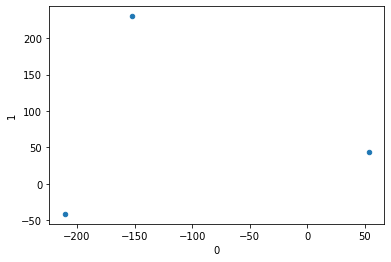

In [143]:
pd.DataFrame(X).plot.scatter(x=0, y=1)